Sumber text clustering using NLTK library: https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb

Sumber text clustering using Spacy library: https://github.com/kirralabs/text-clustering/blob/master/script/core/Clustering.ipynb

# A. Import Library

In [1]:
import os, mpld3, nltk
import numpy as np
import pandas as pd
import re

In [2]:
from spacy.lang.id import Indonesian
import fnmatch
def getAllFileinFolder(folderpath):
    filelist = []
    for dirpath, dirs, files in os.walk(folderpath):
        for filename in fnmatch.filter(files, '*.txt'):
            filelist.append(dirpath + "/" + filename)
    return filelist

def writedataa(list, thname):
    file = open("sentence_rep_{}.txt".format(thname), "w");
    for x in sorted(set(list)):
        # for x in list:
        # hasil = x.replace('"','').replace("#","").replace("&nbsp;","" )
        file.write(x + "\n")
    file.close()

nlp = Indonesian()
def tokenize_and_stem(text):
    text = u'{}'.format(text)
    doc = nlp(text)
    stems = [t.lemma_ for t in doc]
    stems = [t.lower() for t in stems]
    return stems


def tokenize_only(text):
    text = u'{}'.format(text)
    doc = nlp(text)
    stems = [t.text for t in doc]
    stems = [t.lower() for t in stems]
    return stems

# B. Import Dataset

In [3]:
data_raw = pd.read_csv('~/Downloads/data-ticket-karyawan.csv', encoding='utf-8')
data_raw.columns = map(str.lower, data_raw.columns) #membuat huruf awal nama kolom menjadi tidak kapital

sumber = ['Lapor PPDB']
data_raw = data_raw.loc[data_raw['sumber'].isin(sumber)]
data_raw.head(6)

,sumber,tahun bulan,issue id,tracker,created on,closed on,start date,due date,project,subject,state,poin,id resolver,nama resolver,grup resolver,id creator,nama creator,ts menit,wkt resolved,st lembur
0,Lapor PPDB,2024-06,21639,Support,2024-06-29 09:09:00,2024-07-01 05:11:11,2024-06-29,2024-06-29,Kota Denpasar,[Closing Engine] Kota Denpasar 2024 - Jalur Zo...,Closed,NaN,69.0,Febrian Hilmi Firdaus,DSO,69,Febrian Hilmi Firdaus,NaN,2024-06-29 14:30:41,Lembur
1,Lapor PPDB,2024-06,21662,Support,2024-06-29 12:51:50,2024-07-01 05:10:57,2024-06-29,2024-06-29,Prov. Bali,[Kendala] Siswa Masih Bisa Langsung Pengajuan ...,Closed,NaN,69.0,Febrian Hilmi Firdaus,DSO,69,Febrian Hilmi Firdaus,NaN,2024-07-01 05:10:57,Normal
2,Lapor PPDB,2024-06,21088,Support,2024-06-22 05:30:34,2024-06-22 10:18:51,2024-06-22,2024-06-29,Prov. Nusa Tenggara Timur,[Closing Engine] Prov NTT 2024 - SMA All Jalur...,Closed,NaN,69.0,Febrian Hilmi Firdaus,DSO,69,Febrian Hilmi Firdaus,NaN,2024-06-22 08:54:49,Normal
3,Lapor PPDB,2024-06,21689,Support,2024-07-01 02:28:58,2024-07-01 02:46:11,2024-06-30,2024-07-01,Kanwil Prov. DKI Jakarta,[DEV] Pengecekan dan Penyesuaian hasil seleksi...,Closed,5.0,4.0,Azhar Mashuri,DIP,4,Azhar Mashuri,NaN,2024-07-01 02:46:06,Lembur
4,Lapor PPDB,2024-06,21479,Support,2024-06-26 14:13:47,2024-07-01 01:27:33,2024-06-26,2024-06-26,Kota Sukabumi,Pengecekan File Ajuan Pendaftaran di Operator ...,Closed,NaN,74.0,Hayan .,DSO,74,Hayan .,NaN,2024-06-26 14:24:31,Normal
5,Lapor PPDB,2024-06,21680,Support,2024-06-30 19:56:25,2024-06-30 22:43:27,2024-06-30,2024-06-30,Kota Serang,[DEV] Backend - Tolak Pilihan Provinsi Dan Kot...,Closed,1.0,62.0,Villa Nanda,DIP,4,Azhar Mashuri,NaN,2024-06-30 21:41:11,Lembur


In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2036 entries, 0 to 2035
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sumber         2036 non-null   object 
 1   tahun bulan    2036 non-null   object 
 2   issue id       2036 non-null   int64  
 3   tracker        2036 non-null   object 
 4   created on     2036 non-null   object 
 5   closed on      2036 non-null   object 
 6   start date     1630 non-null   object 
 7   due date       2036 non-null   object 
 8   project        2036 non-null   object 
 9   subject        2036 non-null   object 
 10  state          2036 non-null   object 
 11  poin           1712 non-null   float64
 12  id resolver    2036 non-null   float64
 13  nama resolver  2036 non-null   object 
 14  grup resolver  1952 non-null   object 
 15  id creator     2036 non-null   int64  
 16  nama creator   2036 non-null   object 
 17  ts menit       371 non-null    float64
 18  wkt resolved 

### Corpus Loading

In [5]:
corpus = data_raw['subject'].tolist()
corpus[18][0:447]

'Override - Batasan Ajuan Pendaftaran Jalur Zonasi, PTO dan Prestasi'

## 1. Stop Words and Stemming

In [6]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

## 2. The main corpus processing function

STOPWORDS UNTUK BAHASA INDONESIA: https://github.com/stopwords-iso/stopwords-id/blob/132f51cb383abf95a98beb33c4e1afb6933ff884/raw/indonesian-stopwords-complete.txt


Tutorial install nltk: https://www.google.com/search?sca_esv=67eac9aa2b9499b8&sxsrf=ADLYWIKFMpDR9XEWQVPMLfUljnd_t7hZSw:1721699518919&q=nltk+for+mac&tbm=vid&source=lnms&fbs=AEQNm0DVrIRjdA3gRKfJJ-deMT8ZtYOjoIt1NWOMRkEKym4u5PkAZgxJOmIgPx6WieMhF6q1Hq7W6nME2Vp0eHuijF3ZElaTgD0zbj1gkQrti2r6HpgEQJ__FI2P2zVbzOTQnx-xQGuWfPA7_LjHL8X54xCjPigLtLX638JLYGhCvRlpvvGBo-fNpc7q_rU8dgffCadMYeMgxPqmupqDpgcFpVxKo2EBMA&sa=X&ved=2ahUKEwjcuvDBhryHAxXGVmwGHXduBboQ0pQJegQIDBAB&biw=1393&bih=701&dpr=2#fpstate=ive&vld=cid:1e6e69e9,vid:wuQeKgXUZks,st:0

In [24]:
def processCorpus(corpus, language):   
    #stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    #countries_list = [line.rstrip('\n') for line in open('lists/countries.txt')] # Load .txt file line by line
    #nationalities_list = [line.rstrip('\n') for line in open('lists/nationalities.txt')] # Load .txt file line by line
    #other_words = [line.rstrip('\n') for line in open('lists/stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        #corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        #corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        #corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        #corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        #corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        #corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        #listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        #listOfTokens = removeWords(listOfTokens, countries_list)
        #listOfTokens = removeWords(listOfTokens, nationalities_list)
        #listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        #listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

## Install NLTK for Mac

In [10]:
import nltk
import zipfile
import requests

In [11]:
# Step 1: Download the punkt.zip file
url = 'https://github.com/nltk/nltk_data/blob/gh-pages/packages/tokenizers/punkt.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('punkt.zip', 'wb').write(r.content)


13905355

In [12]:
# Step 2: Extract the contents of the zip file
with zipfile.ZipFile('punkt.zip', 'r') as zip_ref:
    zip_ref.extractall('/Users/mac/nltk_data/tokenizers')

In [13]:
# Step 3: Verify if the data is available
from nltk.data import find
find('tokenizers/punkt')

FileSystemPathPointer('/Users/mac/nltk_data/tokenizers/punkt/PY3')

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [15]:
import nltk
from nltk.tokenize import word_tokenize

In [16]:
# Ensure the NLTK data path includes the directory where 'punkt' is located
nltk.data.path.append('/Users/mac/nltk_data')

In [17]:
# Sample text
text = "Hello, how are you?"

In [18]:
# Tokenize the text
tokens = word_tokenize(text)
print(tokens)

['Hello', ',', 'how', 'are', 'you', '?']


## 2. Lanjutan Corpus

In [26]:
language = 'indonesia'
corpus = processCorpus(corpus, language)
corpus[18][0:460]

ValueError: The language 'indonesia' is not supported.

the language 'indonesia' or 'indonesian' is not supported by NLTK's punkt tokenizer. NLTK's punkt tokenizer primarily supports a limited number of languages.

For Indonesian language support, you can use other libraries like Sastrawi or spacy for tokenization.

# Use Spacy Library

### Pilih kolom yang akan digunakan

In [7]:
data_subj = data_raw['subject']
data = data_raw['subject']
data

0       [Closing Engine] Kota Denpasar 2024 - Jalur Zo...
1       [Kendala] Siswa Masih Bisa Langsung Pengajuan ...
2       [Closing Engine] Prov NTT 2024 - SMA All Jalur...
3       [DEV] Pengecekan dan Penyesuaian hasil seleksi...
4       Pengecekan File Ajuan Pendaftaran di Operator ...
                              ...                        
2031    Reset daftar Ajuan Pendaftaran Gabungan zona Demo
2032                    Override Engine Seleksi Kota Batu
2033       Dokumen SPH PPDB Online Kota Palangkaraya 2023
2034    Override Info Dari Formatter Kapasitas Jika Ya...
2035                 Konfirmasi daerah 3 Kota/Kab di TR I
Name: subject, Length: 2036, dtype: object

In [8]:
data.values #Menjadikan array

array(['[Closing Engine] Kota Denpasar 2024 - Jalur Zonasi Kategori Umum - Tahap 1',
       '[Kendala] Siswa Masih Bisa Langsung Pengajuan Pendaftaran di 2 Jenjang Sekaligus',
       '[Closing Engine] Prov NTT 2024 - SMA All Jalur - Tahap 1', ...,
       'Dokumen SPH PPDB Online Kota Palangkaraya 2023',
       'Override Info Dari Formatter Kapasitas Jika Yang Diakses Adalah Kota Batu',
       'Konfirmasi daerah 3 Kota/Kab di TR I'], dtype=object)

### Cleaning data

In [9]:
#Mengubah huruf kapital menjadi lower case
data = data.str.lower()
data

0       [closing engine] kota denpasar 2024 - jalur zo...
1       [kendala] siswa masih bisa langsung pengajuan ...
2       [closing engine] prov ntt 2024 - sma all jalur...
3       [dev] pengecekan dan penyesuaian hasil seleksi...
4       pengecekan file ajuan pendaftaran di operator ...
                              ...                        
2031    reset daftar ajuan pendaftaran gabungan zona demo
2032                    override engine seleksi kota batu
2033       dokumen sph ppdb online kota palangkaraya 2023
2034    override info dari formatter kapasitas jika ya...
2035                 konfirmasi daerah 3 kota/kab di tr i
Name: subject, Length: 2036, dtype: object

In [10]:
def clean_text(text):
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = re.sub(r"2024|2023|ppdb", "", text)
    text = re.sub(r"kota|kab|prov|kotakab|diy", "", text)
    text = re.sub(r"balikpapan|bontang|samarinda|bangka|bantul|barito selatan|batang|berau|bungo|demak|gresik|grobogan|jepara|karimun|klaten|kudus|kulon progo| kutai timur|malang|pati|purbalingga|sleman|jakarta|banjarbaru|batu|bengkulu|bontang|denpasar|jambi|mataram|mojokerto|padang sidempuan|palangkaraya|pasuruan|pontianak|serang|sukabumi|yogyakarta|bali|banten|yogyakarta|jambi|jawa tengah|kalimantan tengah|kalimantan selatan|lampung|ntt|nusa tenggara timur", "", text)
    return text
    

# Apply the function to each element in the 'text' column
data = data.apply(clean_text)

data

0       closing engine     jalur zonasi kategori umum ...
1       kendala siswa masih bisa langsung pengajuan pe...
2               closing engine     sma all jalur  tahap 1
3       dev pengecekan dan penyesuaian hasil seleksi j...
4       pengecekan file ajuan pendaftaran di operator ...
                              ...                        
2031    reset daftar ajuan pendaftaran gabungan zona demo
2032                            override engine seleksi  
2033                               dokumen sph  online   
2034    override info dari formatter kapasitas jika ya...
2035                         konfirmasi daerah 3  di tr i
Name: subject, Length: 2036, dtype: object

In [11]:
data = data.str.replace(r'\s+', ' ', regex=True)
data

0       closing engine jalur zonasi kategori umum tahap 1
1       kendala siswa masih bisa langsung pengajuan pe...
2                    closing engine sma all jalur tahap 1
3       dev pengecekan dan penyesuaian hasil seleksi j...
4       pengecekan file ajuan pendaftaran di operator ...
                              ...                        
2031    reset daftar ajuan pendaftaran gabungan zona demo
2032                             override engine seleksi 
2033                                  dokumen sph online 
2034    override info dari formatter kapasitas jika ya...
2035                          konfirmasi daerah 3 di tr i
Name: subject, Length: 2036, dtype: object

In [12]:
data.values

array(['closing engine jalur zonasi kategori umum tahap 1',
       'kendala siswa masih bisa langsung pengajuan pendaftaran di 2 jenjang sekaligus',
       'closing engine sma all jalur tahap 1', ..., 'dokumen sph online ',
       'override info dari formatter kapasitas jika yang diakses adalah ',
       'konfirmasi daerah 3 di tr i'], dtype=object)

In [13]:
data.info()

<class 'pandas.core.series.Series'>
Index: 2036 entries, 0 to 2035
Series name: subject
Non-Null Count  Dtype 
--------------  ----- 
2036 non-null   object
dtypes: object(1)
memory usage: 31.8+ KB


## Stopwords Indonesia

STOPWORDS UNTUK BAHASA INDONESIA: https://github.com/stopwords-iso/stopwords-id/blob/132f51cb383abf95a98beb33c4e1afb6933ff884/raw/indonesian-stopwords-complete.txt

In [14]:
stopword_ind = open('indonesian-stopwords-complete.txt')
stopword_ind = list(stopword_ind)
stopword_ind = [word.strip() for word in stopword_ind]
#cleaned_words = [word.replace('\n', '') for word in words]
#stopword_ind

## Tokenization

In [15]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
from __future__ import print_function
totalvocab_stemmed = []
totalvocab_tokenized = []
dataarticle = list(data.values)
count = 0
for i in dataarticle:
    print("\rArticle process: {} from {}".format(count+1, len(dataarticle)), end="")
    count += 1
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
print ("")
print ("")

print ("total vacab stem: ", len(totalvocab_stemmed))
print ("total vacab tokenize: ",len(totalvocab_tokenized))

Article process: 2036 from 2036

total vacab stem:  14269
total vacab tokenize:  14269


In [16]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
# vocab_frame[:10] #print 10 word

there are 14269 items in vocab_frame


Ada 2 versi dalam Vectorization:


1. vectorizer_model = CountVectorizer(ngram_range=(2, 2),
                                   stop_words=stopword_ind)

   - code ini akan digunakan pada bagian BERT penetuan topic di akhir

   
3. tfidf_vectorizer = TfidfVectorizer()
   
   - ini berasal dari
   - tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 #min_df=2, stop_words=stopword_ind,
                                 #use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
   - Namun code ini error pada min dan max nya
   - Akan digunakan pada bagian ini

In [17]:
from spacy.lang.id import stop_words
from string import punctuation, digits
from sklearn.feature_extraction.text import TfidfVectorizer

# ERROR PADA MIN DF DAN MAX DF NYA
#tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 #min_df=2, stop_words=stopword_ind,
                                 #use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(list(data.values)) #fit the vectorizer to synopses

print("TF-idf matrix: ",tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names_out()

TF-idf matrix:  (2036, 1212)


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
dist

array([[ 0.00000000e+00,  1.00000000e+00,  5.21789195e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00, -2.22044605e-16,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  9.37112753e-01],
       [ 5.21789195e-01,  1.00000000e+00, -2.22044605e-16, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
        -2.22044605e-16,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00, -2.22044605e-16,  1.00000000e+00],
       [ 1.00000000e+00,  9.37112753e-01,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

## Elbow methods

Sumber: https://medium.com/@rohithramesh1991/unsupervised-text-clustering-using-natural-language-processing-nlp-1a8bc18b048d

In [19]:
from tqdm import tqdm
from sklearn.cluster import KMeans

In [20]:
#checking for optimal number of clusters
SSD = []
K = range(1,150)
for k in K:
    kmm = KMeans (n_clusters=k)
    kmm = kmm.fit (tfidf_matrix)
    SSD.append(kmm.inertia_)

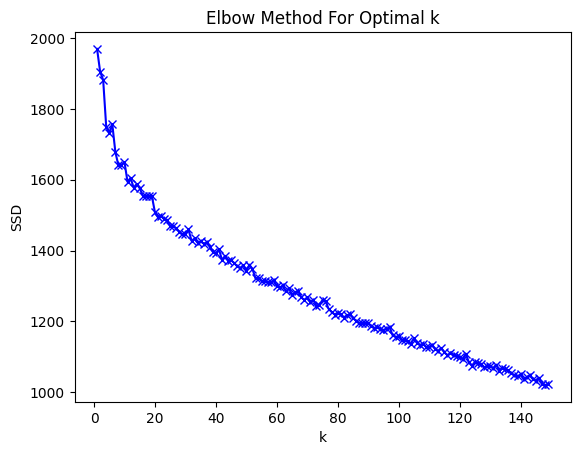

In [21]:
import matplotlib.pyplot as plt

plt.plot(K, SSD, 'bx-')
plt.xlabel('k')
plt.ylabel('SSD')
plt.title('Elbow Method For Optimal k')
plt.show()

Berdasarkan grafik dapat dilihat bahwa maksimum k nya adalah antara 0 sampai 20

## KMeans

In [22]:
from sklearn.cluster import KMeans

num_clusters = 20

km = KMeans(n_clusters=num_clusters, random_state=...)
#random_state=...) agar tidak berubah-ubah

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [23]:
output = { 'subject': list(data_subj.values),'subject_p': list(data.values), 'cluster': clusters }

data_hsl = pd.DataFrame(output, index = [clusters] , columns = ['subject','subject_p','cluster'])
data_hsl

,subject,subject_p,cluster
6,[Closing Engine] Kota Denpasar 2024 - Jalur Zo...,closing engine jalur zonasi kategori umum tahap 1,6
8,[Kendala] Siswa Masih Bisa Langsung Pengajuan ...,kendala siswa masih bisa langsung pengajuan pe...,8
6,[Closing Engine] Prov NTT 2024 - SMA All Jalur...,closing engine sma all jalur tahap 1,6
18,[DEV] Pengecekan dan Penyesuaian hasil seleksi...,dev pengecekan dan penyesuaian hasil seleksi j...,18
5,Pengecekan File Ajuan Pendaftaran di Operator ...,pengecekan file ajuan pendaftaran di operator ...,5
...,...,...,...
5,Reset daftar Ajuan Pendaftaran Gabungan zona Demo,reset daftar ajuan pendaftaran gabungan zona demo,5
18,Override Engine Seleksi Kota Batu,override engine seleksi,18
3,Dokumen SPH PPDB Online Kota Palangkaraya 2023,dokumen sph online,3
17,Override Info Dari Formatter Kapasitas Jika Ya...,override info dari formatter kapasitas jika ya...,17


In [24]:
data_hsl['cluster'].value_counts() #number of article per cluster (clusters from 0 to 4)

cluster
17    321
8     303
5     149
10    141
4     128
12    119
14    110
18     99
1      91
7      79
2      78
13     69
19     69
3      65
9      58
15     57
6      37
16     27
11     20
0      16
Name: count, dtype: int64

ALTERNATIF LAIN UNTUK MENAMPILKAN TOPIC DAN SUBJECT TIAP CLUSTER

from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d topics:" % i, end='')
    
    for ind in order_centroids[i, :4]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d subject:" % i, end='')
    for title in data_hsl.loc[i]['subject_p'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

In [25]:
from __future__ import print_function

print("Anggota per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    #UNTUK MENAMPILKAN TOPIC (MASIH ERROR)
    #print(f"Cluster {i} topic:", end='') 
    #for ind in order_centroids[i, :4]:  # Replace 6 with n_words_per_cluster
        #word = terms[ind].split(' ')
        #if word[0] in vocab_frame.index:
            #print(f" {vocab_frame.loc[word[0]].values.tolist()[0][0].encode('utf-8', 'ignore').decode('utf-8')},", end='')
    #print()  # Add whitespace
    #print()  # Add whitespace

    print(f"Cluster {i} subject:", end='')
    if i in data_hsl.index:
        for title in data_hsl.loc[i]['subject_p'].values.tolist():
            print(f" {title},", end='')
    print()  # Add whitespace
    print()  # Add whitespace
    
print()
print()

Anggota per cluster:

Cluster 0 subject: menghapus waktu pendaftaran pada detil siswa, dev menghapus waktu pendaftaran pada detil siswa, devtampilan maps pada halaman konfirmasi pengajuan pendaftaran masih menampilkan peta osm, sembunyikan informasi akreditasi sekolah asal pada halaman ajuan akun, dev penutupan halaman detil siswa 48310323220746 pada situs arsip 2017, dev menampilkan halaman konfirmasicek ulang pada situs publik sesuai asal sekolah lulusan, dev backend aggregator konten halaman data zonasi sekolah di situs publik, dev frontend halaman data zonasi sekolah di situs publik, dev tampilkan info pada halaman verifikasi dan tolak ajuan akun, dev muncul notifikasi halaman ini belum dapat diaksesjalur bibit unggul, dev sembunyikan informasi akreditasi sekolah asal pada halaman ajuan akun, dev ubah tampilkan info status verifikasi di detil siswa, dev frontend menampilkan halaman memasukkan token ketika login, refresh portal halaman tidak ditemukan, pencarian detil arsip error, r

# Data tiap Cluster

In [95]:
cluster0 = data_hsl[data_hsl['cluster'] == 0]
data_cls0 = cluster0['subject_p']
data_cls0

0         menghapus waktu pendaftaran pada detil siswa
0     dev menghapus waktu pendaftaran pada detil siswa
0    devtampilan maps pada halaman konfirmasi penga...
0    sembunyikan informasi akreditasi sekolah asal ...
0    dev penutupan halaman detil siswa 483103232207...
0    dev menampilkan halaman konfirmasicek ulang pa...
0    dev backend aggregator konten halaman data zon...
0    dev frontend halaman data zonasi sekolah di si...
0    dev tampilkan info pada halaman verifikasi dan...
0    dev muncul notifikasi halaman ini belum dapat ...
0    dev sembunyikan informasi akreditasi sekolah a...
0    dev ubah tampilkan info status verifikasi di d...
0    dev frontend menampilkan halaman memasukkan to...
0               refresh portal halaman tidak ditemukan
0                          pencarian detil arsip error
0               refresh portal halaman tidak ditemukan
Name: subject_p, dtype: object

In [110]:
#cluster1 = data_hsl[data_hsl['cluster'] == 1]
data_cls1 = data_hsl[data_hsl['cluster'] == 1]['subject_p']
data_cls1

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


1                              proses deploy data
1           migrasi data lulusan asal sekolah sd 
1                proses migrasi data master siswa
1    proses migrasi data siswa lulusan sd dan mi 
1       proses migrasi data siswa lulusan suumi 2
                         ...                     
1                 deploy production data lulusan 
1           proses migrasi data siswa lulusan sd 
1                            deploy data lulusan 
1      database migrasi data siswa proses migrasi
1                                  proses migrasi
Name: subject_p, Length: 91, dtype: object

In [71]:
cluster2 = data_hsl[data_hsl['cluster'] == 2]
data_cls2 = cluster2['subject_p']

In [132]:
cluster11 = data_hsl[data_hsl['cluster'] == 11]
data_cls11 = cluster11['subject_p']

In [72]:
cluster3 = data_hsl[data_hsl['cluster'] == 3]
data_cls3 = cluster3['subject_p']

In [73]:
cluster4 = data_hsl[data_hsl['cluster'] == 4]
data_cls4 = cluster4['subject_p']

In [74]:
cluster5 = data_hsl[data_hsl['cluster'] == 5]
data_cls5 = cluster5['subject_p']

In [75]:
cluster6 = data_hsl[data_hsl['cluster'] == 6]
data_cls6 = cluster6['subject_p']

In [111]:
data = []

for i in range(20):
    data.append(data_hsl[data_hsl['cluster'] == i]['subject_p'])
    

In [120]:
data[0]

0         menghapus waktu pendaftaran pada detil siswa
0     dev menghapus waktu pendaftaran pada detil siswa
0    devtampilan maps pada halaman konfirmasi penga...
0    sembunyikan informasi akreditasi sekolah asal ...
0    dev penutupan halaman detil siswa 483103232207...
0    dev menampilkan halaman konfirmasicek ulang pa...
0    dev backend aggregator konten halaman data zon...
0    dev frontend halaman data zonasi sekolah di si...
0    dev tampilkan info pada halaman verifikasi dan...
0    dev muncul notifikasi halaman ini belum dapat ...
0    dev sembunyikan informasi akreditasi sekolah a...
0    dev ubah tampilkan info status verifikasi di d...
0    dev frontend menampilkan halaman memasukkan to...
0               refresh portal halaman tidak ditemukan
0                          pencarian detil arsip error
0               refresh portal halaman tidak ditemukan
Name: subject_p, dtype: object

In [131]:
data[19]

19    override perubahan redaksi pendaftaran siswa d...
19    database proses migrasi database tambahan batch 2
19     dev perubahan redaksi pendaftaran siswa database
19              menambah storage pada vm database slave
19           st menambah storage pada vm database slave
                            ...                        
19    penyediaan vm oci untuk database slave all wil...
19    sinkronisasi struktur database penambahan alam...
19    sinkronisasi struktur database penambahan alam...
19    restorasi database psbdbpublik dengan backup 9...
19    st penyediaan vm oci untuk database slave all ...
Name: subject_p, Length: 69, dtype: object

# IndoBERT

## Topic generation (Contoh)

In [44]:
from bertopic import BERTopic
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer


import seaborn as sns
import matplotlib.pyplot as plt

1. CountVectorizer:
Ini adalah kelas dari scikit-learn yang digunakan untuk mengubah teks menjadi representasi angka (vector). CountVectorizer menghitung frekuensi kata atau n-gram dalam dokumen teks.

2. ngram_range=(2, 2):
Parameter ngram_range menentukan rentang n-gram yang akan diekstraksi dari teks. Dalam kasus ini, (2, 2) berarti model hanya akan mengekstrak bigram (sepasang kata berturut-turut) dari teks. Sebagai contoh, dari teks "saya suka membaca buku", bigram yang dihasilkan adalah "saya suka", "suka membaca", dan "membaca buku".

3. stop_words=stopword_ind:
Parameter stop_words digunakan untuk menentukan daftar kata-kata yang akan diabaikan (dihapus) dari teks sebelum proses n-gram dilakukan. stopword_ind di sini adalah variabel yang menyimpan daftar kata-kata umum dalam bahasa Indonesia (seperti "dan", "di", "yang", dll.) yang tidak dianggap penting untuk analisis.

1. BERTopic:

BERTopic adalah library yang digunakan untuk pemodelan topik berbasis embedding teks. Model ini menggabungkan transformer berbasis BERT dengan algoritma clustering untuk menemukan dan memvisualisasikan topik dalam teks.

2. top_n_words=10:

Parameter ini menentukan jumlah kata teratas yang akan diambil untuk setiap topik. Dalam hal ini, 10 kata teratas akan diambil untuk menggambarkan setiap topik.

3. n_gram_range=(2, 2):

Parameter ini menentukan rentang n-gram yang akan digunakan dalam pemrosesan teks. (2, 2) berarti model akan menggunakan bigram (sepasang kata berturut-turut).

4. nr_topics=7:

Parameter ini menentukan jumlah topik yang akan diekstraksi dari teks. Dalam kasus ini, model akan mencoba menemukan 7 topik.

5. vectorizer_model=vectorizer_model:

Parameter ini memungkinkan kita untuk menentukan model vectorizer yang telah kita buat sebelumnya. Dalam hal ini, vectorizer_model adalah objek CountVectorizer yang dikonfigurasi untuk menghasilkan bigram dan mengabaikan stop words dalam bahasa Indonesia.

6. umap_model=UMAP(random_state=1):

UMAP (Uniform Manifold Approximation and Projection) adalah algoritma untuk reduksi dimensi yang sering digunakan untuk visualisasi data tinggi dimensi. random_state=1 memastikan bahwa hasil reduksi dimensi bisa direproduksi (konsisten setiap kali dijalankan).

In [89]:
# create a list of speeches
docs = data_cls1.tolist()

vectorizer_model = CountVectorizer(ngram_range=(3, 3),
                                   stop_words=stopword_ind)

# generate a bigram topic model with 10 top terms and 8 topics
bertopic_model = BERTopic(top_n_words=5,
                          n_gram_range=(3,3),
                          nr_topics=2,
                          vectorizer_model=vectorizer_model,
                          umap_model = UMAP(random_state=1))  # setting seed topics reproduce

# fit the model to data
topics, probabilities = bertopic_model.fit_transform(docs)

In [90]:
# topic visualization
topic = pd.DataFrame(bertopic_model.get_topic(0), columns=["Topic", "Prob"])
topics_df = pd.concat([topic], axis=1)
topics_df

,Topic,Prob
0,data siswa lulusan,0.158833
1,migrasi data siswa,0.143345
2,proses migrasi data,0.101033
3,siswa lulusan insi,0.093922
4,migrasi data lulusan,0.087203


In [46]:
print(topics)

[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]


In [47]:
print(probabilities)

[0.3592418  0.74899098 0.76541941 1.         1.         1.
 1.         0.65155858 0.77706746 0.75430414 0.77706746 1.
 1.         0.76541941 1.         1.         0.96944227 0.9419092
 1.         1.         1.         1.         1.         0.96163026
 1.         1.         0.84183046 1.         1.         0.92037242
 1.         0.77706746 1.         0.73302157 0.87262871 1.
 1.         0.60107845 0.8408549  0.71630456 1.         1.
 1.         1.         0.77706746 0.52726463 1.         0.84479305
 1.         1.         0.70635624 1.         1.         1.
 0.58634112 0.85065576 0.81659991 1.         1.         0.71720617
 0.76820937 0.77109391 1.         0.83280496 0.45056448 0.90127799
 0.7884704  1.         0.86091816 1.         0.95495571 1.
 1.         0.94651973 0.89111917 1.         1.         0.36853229
 1.         1.         0.88704276 0.63389215 0.44369967 1.
 1.         0.83372714 0.49285115 1.         0.45489056 0.7381336
 0.69020473]


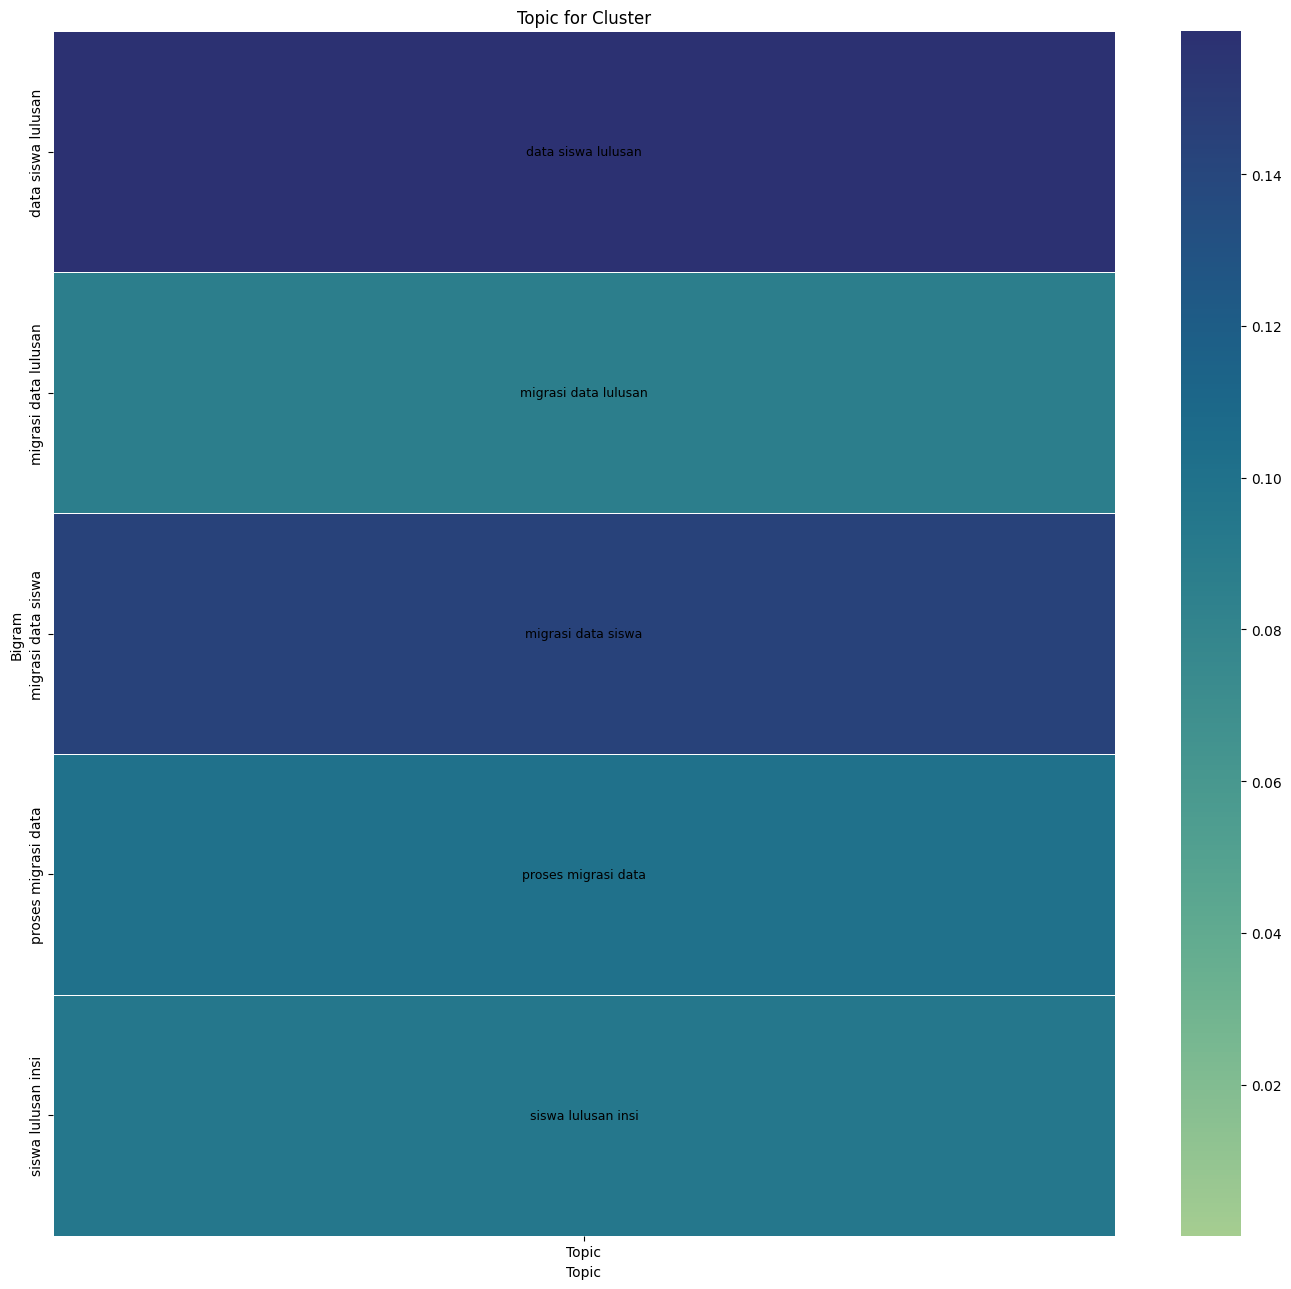

In [49]:
## topic visualization - heatmap

# Initialize DataFrame to store reshaped data
reshaped_data = pd.DataFrame(columns=['Bigram', 'Topic', 'Prob'])

# Reshape data from original DataFrame
for i in range(1, 2):
    topic_word_col = f'Topic'
    topic_prob_col = f'Prob'
    temp_df = pd.DataFrame({
        'Bigram': topics_df[topic_word_col],
        'Topic': f'Topic',
        'Prob': topics_df[topic_prob_col]
    })
    reshaped_data = pd.concat([reshaped_data, temp_df])

# Set 'Bigram' as index
reshaped_data.set_index('Bigram', inplace=True)

# Create pivot table for heatmap
pivot_table = reshaped_data.pivot(columns='Topic', values='Prob').fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 13))
cmap = sns.color_palette("crest", as_cmap=True)
cmap.set_under(color='white')

# Generate heatmap
sns.heatmap(pivot_table, cmap=cmap, linewidths=0.5, annot=False,
            cbar=True, mask=(pivot_table == 0), vmin=0.0001)

# Add bigrams with non-zero probability on top of the heatmap
for i, bigram in enumerate(pivot_table.index):
    for j, topic in enumerate(pivot_table.columns):
        if pivot_table.loc[bigram, topic] > 0:
            plt.text(j + 0.5, i + 0.5, bigram, ha='center', va='center',
                     color='black' if pivot_table.loc[bigram, topic] > 0 else 'white', fontsize=9)

# Customize plot
plt.title('Topic for Cluster')
plt.xlabel('Topic')
plt.ylabel('Bigram')
plt.tight_layout()
plt.savefig("BERTopic_Russia.png")
plt.show()

## Cluster 0 (Error)

In [154]:
# create a list of speeches
docs = data_cls0.tolist()

vectorizer_model = CountVectorizer(ngram_range=(1, 1),
                                   stop_words=stopword_ind)


# generate a bigram topic model with 10 top terms and 8 topics
bertopic_model = BERTopic(top_n_words=1,
                          n_gram_range=(1,2),
                          nr_topics='auto',
                          min_topic_size=2,
                          calculate_probabilities=True,
                          vectorizer_model=vectorizer_model,
                          umap_model = UMAP(random_state=1))  # setting seed topics reproduce
#bertopic_model = BERTopic()
# fit the model to data
topics, probabilities = bertopic_model.fit_transform(docs)

In [150]:
docs

['menghapus waktu pendaftaran pada detil siswa',
 'dev menghapus waktu pendaftaran pada detil siswa',
 'devtampilan maps pada halaman konfirmasi pengajuan pendaftaran masih menampilkan peta osm',
 'sembunyikan informasi akreditasi sekolah asal pada halaman ajuan akun',
 'dev penutupan halaman detil siswa 48310323220746 pada situs arsip 2017',
 'dev menampilkan halaman konfirmasicek ulang pada situs publik sesuai asal sekolah lulusan',
 'dev backend aggregator konten halaman data zonasi sekolah di situs publik',
 'dev frontend halaman data zonasi sekolah di situs publik',
 'dev tampilkan info pada halaman verifikasi dan tolak ajuan akun',
 'dev muncul notifikasi halaman ini belum dapat diaksesjalur bibit unggul',
 'dev sembunyikan informasi akreditasi sekolah asal pada halaman ajuan akun',
 'dev ubah tampilkan info status verifikasi di detil siswa',
 'dev frontend menampilkan halaman memasukkan token ketika login',
 'refresh portal halaman tidak ditemukan',
 'pencarian detil arsip error

In [157]:
# topic visualization
topic = pd.DataFrame(bertopic_model.get_topic(0), columns=["Topic", "Prob"])
topics_df = pd.concat([topic], axis=1)
topics_df

,Topic,Prob
0,pendaftaran,0.162933


In [156]:
bertopic_model.get_topic(0)

[('pendaftaran', 0.1629331336616537)]

## Cluster 1 (migrasi data)

In [125]:
# create a list of speeches
docs = data_cls1.tolist()

vectorizer_model = CountVectorizer(ngram_range=(3, 3),
                                   stop_words=stopword_ind)

# generate a bigram topic model with 10 top terms and 8 topics
bertopic_model = BERTopic(top_n_words=5,
                          n_gram_range=(3,3),
                          nr_topics=2,
                          vectorizer_model=vectorizer_model,
                          umap_model = UMAP(random_state=1))  # setting seed topics reproduce

# fit the model to data
topics, probabilities = bertopic_model.fit_transform(docs)

In [126]:
bertopic_model.get_topic(0)

False

In [105]:
# topic visualization
topic = pd.DataFrame(bertopic_model.get_topic(0), columns=["Topic", "Prob"])
topics_df = pd.concat([topic], axis=1)
topics_df

,Topic,Prob
0,data siswa lulusan,0.158833
1,migrasi data siswa,0.143345
2,proses migrasi data,0.101033
3,siswa lulusan insi,0.093922
4,migrasi data lulusan,0.087203


## Cluster 2 (deploy riil)

In [106]:
# create a list of speeches
docs = data_cls2.tolist()

vectorizer_model = CountVectorizer(ngram_range=(3, 3),
                                   stop_words=stopword_ind)

# generate a bigram topic model with 10 top terms and 8 topics
bertopic_model = BERTopic(top_n_words=5,
                          n_gram_range=(3,3),
                          nr_topics=2,
                          vectorizer_model=vectorizer_model,
                          umap_model = UMAP(random_state=1))  # setting seed topics reproduce

# fit the model to data
topics, probabilities = bertopic_model.fit_transform(docs)

In [107]:
# topic visualization
topic = pd.DataFrame(bertopic_model.get_topic(0), columns=["Topic", "Prob"])
topics_df = pd.concat([topic], axis=1)
topics_df

,Topic,Prob
0,deploy riil deploy,0.333774
1,riil deploy riil,0.328906
2,riil infra deploy,0.225154
3,infra deploy riil,0.225154
4,deploy riil infra,0.225154


## Cluster 3 (pengiriman sph)

In [108]:
# create a list of speeches
docs = data_cls3.tolist()

vectorizer_model = CountVectorizer(ngram_range=(3, 3),
                                   stop_words=stopword_ind)

# generate a bigram topic model with 10 top terms and 8 topics
bertopic_model = BERTopic(top_n_words=5,
                          n_gram_range=(3,3),
                          nr_topics=2,
                          vectorizer_model=vectorizer_model,
                          umap_model = UMAP(random_state=1))  # setting seed topics reproduce

# fit the model to data
topics, probabilities = bertopic_model.fit_transform(docs)

In [109]:
# topic visualization
topic = pd.DataFrame(bertopic_model.get_topic(0), columns=["Topic", "Prob"])
topics_df = pd.concat([topic], axis=1)
topics_df

,Topic,Prob
0,pengiriman sph online,0.212265
1,sph nego online,0.184254
2,online pengiriman sph,0.162587
3,pengiriman sph nego,0.162587
4,nego online pengiriman,0.116188
